# Imports

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [6]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))
from bayesflow.forward_inference import *
from bayesflow.diagnostics import *
from bayesflow.configuration import *
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.trainers import Trainer

In [7]:
import tensorflow as tf

In [8]:
%load_ext autoreload
%autoreload 2

# User-defined functions

In [9]:
def prior_fun():
    return np.random.normal(size=3)

def generator(params, n_obs=50):
    return np.random.normal(params, size=(n_obs, params.shape[0]))

# Generative Model Interface

In [10]:
sim = Simulator(simulator_fun=generator)

In [11]:
gen_model = GenerativeModel(prior_fun, sim)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 50, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Networks and Amortizer

In [12]:
summary_net = InvariantNetwork({'summary_dim': 10})
inference_net = InvertibleNetwork({
    'n_params': 3, 
    'n_coupling_layers': 2,
})
amortizer = AmortizedPosterior(inference_net, summary_net)

In [13]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=50,
    decay_rate=0.9,
)

In [26]:
# change var_obs
trainer = Trainer(amortizer=amortizer, 
                  learning_rate=lr_schedule,
                  generative_model=gen_model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [27]:
h = trainer.train_online(epochs=2, iterations_per_epoch=50, batch_size=32)

Training epoch 1:   0%|          | 0/50 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/50 [00:00<?, ?it/s]

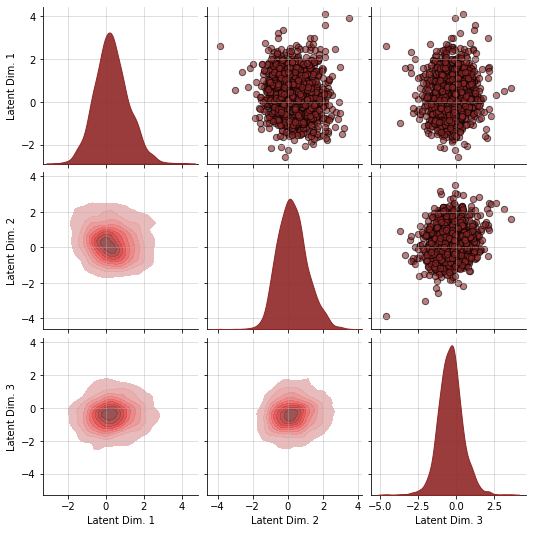

In [24]:
f = trainer.diagnose_latent()

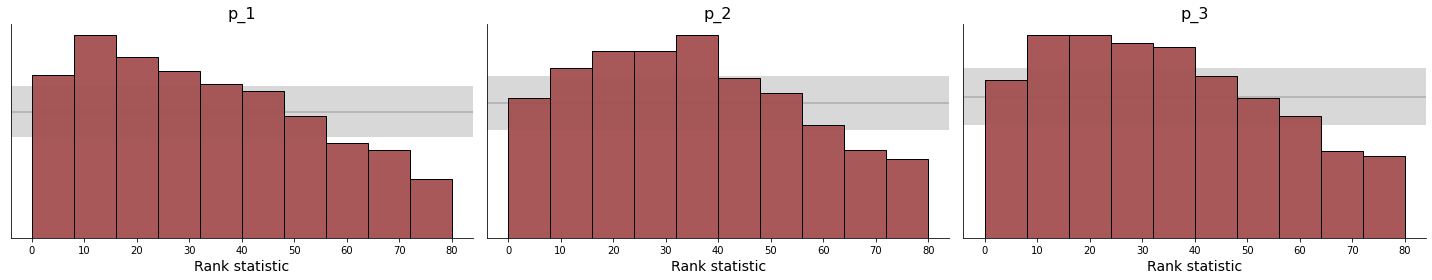

In [28]:
f = trainer.diagnose_sbc()

# Validation

In [ ]:
f = plot_losses(h)

In [ ]:
val = trainer.configurator(gen_model(100))

In [ ]:
z, _ = amortizer(val)

In [ ]:
f = plot_latent_space_2d(z)

In [ ]:
post_draws = amortizer.sample(val, n_samples = 100)

In [ ]:
f = plot_recovery(post_draws, val['parameters'])

In [ ]:
val = trainer.configurator(gen_model(1000))
post_draws = amortizer.sample(val, n_samples = 25)
f = plot_sbc(post_draws, val['parameters'])

In [ ]:
h2 = trainer.train_rounds(rounds=2, sim_per_round=64, epochs=3, batch_size=16)